In [1]:
import json
import os
import numpy as np
import pandas as pd
import dgl
import dgl.function as fn

import torch
import torch.nn as nn

import gc

# Data Preprocess

In [5]:
folder = 'OAG_Venue'
path = '/home/chenshangheng/Desktop/LMPG/data'
is_vocabulary = True

meta_data_path = {
    "paper": "paper2token.csv",
    "title": "title2token.csv",
    "field_of_study": "field2token.csv",
    "author": "author2token.csv",
    "institution": "affiliation2token.csv",
}
center_node_type = "paper"
center_edge = ('cites', 'paper')
feat_name = {
    "paper": "P",
    "field_of_study": "F",
    "author": "A",
    "institution": "I",
}

edge_name = {
    'affiliated_with': ['A', 'I'],
    'writes': ['A', 'P'],
    'rev_has_topic': ['F', 'P'],
    'rev_affiliated_with': ['I', 'A'],
    'cites': ['P', 'P'],
    'has_topic': ['P', 'F'],
    'rev_writes': ['P', 'A']
}

link_prediction_type = 'writes'

In [3]:
data_dict = {}
for k in meta_data_path:
    data_path = os.path.join(folder, meta_data_path[k])
    data_dict[k] = pd.read_csv(data_path).dropna().drop_duplicates()

In [4]:
graph_path = os.path.join(folder, 'model', 'bert_raw-001.pkl')
dataset = dgl.load_graphs(graph_path)
graph = dataset[0][0]
etypes = {ntype: [] for ntype in graph.ntypes}
embedding = dict()
for ntype in graph.ntypes:
    if "feat" in graph.nodes[ntype].data:
        embedding[ntype] = graph.nodes[ntype].data["feat"]

node_num = {}
nodeEmb = nn.ModuleDict()
for ntype in graph.ntypes:
    node_num[ntype] = len(graph.nodes(ntype))
    nor_feat = graph.nodes[ntype].data["feat"]

    nodeEmb[ntype] = nn.Embedding.from_pretrained(
        torch.cat([nor_feat, torch.zeros(1, nor_feat.shape[1])], dim=0), freeze=True)

for stype, etype, dtype in graph.canonical_etypes:
    etypes[stype].append((etype, dtype))

In [5]:
# Remove the node without text
graph_node_set = set(graph.nodes(center_node_type).numpy().tolist())
text_node_set = set(data_dict[center_node_type]["ent idx"].values)
null_value_list = list(graph_node_set ^ text_node_set)
not_null_value_list = list(graph_node_set & text_node_set)
graph = dgl.remove_nodes(graph, torch.tensor(null_value_list), ntype=center_node_type)
data_dict[center_node_type].sort_values(by=['ent idx'],ascending=True)
data_dict[center_node_type]['ent idx'] = np.arange(len(data_dict[center_node_type]))

labels = dataset[1]
labels[center_node_type] = labels[center_node_type][not_null_value_list]
dgl.save_graphs(os.path.join(folder, 'model', 'bert_pretrain.pkl') , graph, labels=labels)

In [45]:
texts = []
for x in data_dict[center_node_type].values[:, -1]:
    text = str(x).replace(" ", "")[1:-1].split(",")[1:]
    texts.append(' '.join(text))


In [46]:
layer_num = 2
return_dict = [{ntype: [] for ntype in etypes.keys()} for i in range(3)]
def sampleNei(ntype: dict, etypes: list, nei_num: int) -> dict:
        neigh_layer_1 = dgl.sampling.sample_neighbors(graph, ntype, nei_num, edge_dir='out')
        neigh_nodes = {dtype: set() for etype, dtype in etypes}
        for etype_tuple in etypes:
            etype, dsttype = etype_tuple
            neigh_nodes[dsttype].update(neigh_layer_1.edges(etype=etype)[1].unique().numpy().tolist())
        for ntype, nodes in neigh_nodes.items():
            neigh_nodes[ntype] = nodes
        return neigh_nodes
layer_num = 2
nei_num = 5
graph_neighbours = {}
for nid in graph.nodes(center_node_type).numpy().tolist():
    graph_neighbour = {}
    preNeis = {center_node_type: set([nid])}
    neighbour_nodes = sampleNei({center_node_type: [nid]}, [('cites', 'paper')], nei_num)
    text_neighbour_id = list(neighbour_nodes[center_node_type])
    # if len(text_neighbour_id) == 0:
    #     continue
    high_Neis_dict = {center_node_type: set([nid])}
    for i in range(layer_num):
        i_Nei = {}
        for stype, sids in preNeis.items():
            if len(sids) != 0:
                neighbour_nodes = sampleNei({stype: list(sids)}, etypes[stype], nei_num)
                for dtype, dids in neighbour_nodes.items():
                    if len(dids) == 0:
                        continue
                    if dtype not in i_Nei:
                        i_Nei[dtype] = set()
                    i_Nei[dtype].update(dids)

        for stype, sids in i_Nei.items():
            i_Nei[stype] = sids
            if stype not in high_Neis_dict:
                high_Neis_dict[stype] = set()
            high_Neis_dict[stype].update(i_Nei[stype])

        preNeis = i_Nei
    for type, id in high_Neis_dict.items():
        high_Neis_dict[type] = torch.tensor(list(id))
    
    graph_neighbours[nid] = [high_Neis_dict, text_neighbour_id]


In [47]:
torch.manual_seed(seed=2024)
train_rate, test_rate = 0.7, 0.1
node_len = graph.number_of_nodes(center_node_type)
permute_idx = torch.randperm(node_len)
train_len, test_len = int(node_len*train_rate), int(node_len*test_rate)
node_split_idx = {'train':{center_node_type: torch.tensor(permute_idx[:train_len])}, 
                  'valid':{center_node_type: torch.tensor(permute_idx[train_len:node_len-test_len])},
                  'test':{center_node_type: torch.tensor(permute_idx[node_len-test_len:])}}

edge_split_idx = {}

for k in node_split_idx:
    edge_idx_lst = []
    for node_id in node_split_idx[k][center_node_type]:
        edge_idx = graph.in_edges(node_id, etype=link_prediction_type,form='eid')
        if len(edge_idx) != 0:
            edge_idx_lst.append(int(edge_idx[0]))
    edge_split_idx[k] = {center_node_type: torch.tensor(edge_idx_lst)}



/tmp/ipykernel_14610/1905231611.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_split_idx = {'train':{center_node_type: torch.tensor(permute_idx[:train_len])},
/tmp/ipykernel_14610/1905231611.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'valid':{center_node_type: torch.tensor(permute_idx[train_len:node_len-test_len])},
/tmp/ipykernel_14610/1905231611.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'test':{center_node_type: torch.tensor(permute_idx[node_len-test_len:])}}


In [48]:
torch.save(node_split_idx, os.path.join(folder, 'downstream', 'node_split_idx.pkl'))
torch.save(edge_split_idx, os.path.join(folder, 'downstream', 'edge_split_idx.pkl'))


In [49]:
g = graph.clone()

# Combine edges of different types into one type
src_cites, dst_cites = g.edges(etype='cites')
src_rev_cites, dst_rev_cites = g.edges(etype='rev_cites')

new_src = torch.cat([src_cites, src_rev_cites])
new_dst = torch.cat([dst_cites, dst_rev_cites])

# Get the edge IDs of the original edges
edge_ids_cites = g.edge_ids(src_cites, dst_cites, etype='cites').squeeze()
edge_ids_rev_cites = g.edge_ids(src_rev_cites, dst_rev_cites, etype='rev_cites').squeeze()

# Remove the original edges using edge IDs
g.remove_edges(edge_ids_cites, etype='cites')
g.remove_edges(edge_ids_rev_cites, etype='rev_cites')

# Add the combined edges with a new edge type
g.add_edges(new_src, new_dst, etype='cites')

# 获得所有边类型
edge_types = g.etypes
filtered_edge_types = [etype for etype in edge_types if etype != 'rev_cites']
g = g.edge_type_subgraph(filtered_edge_types)

# 遍历节点数据字典，创建新的键并复制值
for k in feat_name:
    tmp = g.nodes[k].data['feat']
    g.nodes[k].data.clear()
    g.nodes[k].data[feat_name[k]] = tmp


In [50]:
new_edges = {}
edge_types = g.etypes
for edge_type in edge_types:
    adj = g.edges(etype=edge_type)
    src_type, dst_type = edge_name[edge_type]
    new_edges[(src_type, src_type+'-'+dst_type, dst_type)] = adj

new_graph = dgl.heterograph(new_edges)

for k in feat_name:
    v = feat_name[k]
    new_graph.nodes[v].data[v] = g.nodes[k].data[v]

g = new_graph

In [51]:
def hg_propagate_feat_dgl(g, tgt_type, num_hops, max_length, extra_metapath, echo=False):
    for hop in range(1, max_length):
        reserve_heads = [ele[:hop] for ele in extra_metapath if len(ele) > hop]
        for etype in g.etypes:
            stype, _, dtype = g.to_canonical_etype(etype)
            # if hop == args.num_hops and dtype != tgt_type: continue
            for k in list(g.nodes[stype].data.keys()):
                if len(k) == hop:
                    current_dst_name = f'{dtype}{k}'
                    if (hop == num_hops and dtype != tgt_type and k not in reserve_heads) \
                      or (hop > num_hops and k not in reserve_heads):
                        continue
                    if echo: print(k, etype, current_dst_name)
                    g[etype].update_all(
                        fn.copy_u(k, 'm'),
                        fn.mean('m', current_dst_name), etype=etype)

        # remove no-use items
        for ntype in g.ntypes:
            if ntype == tgt_type: continue
            removes = []
            for k in g.nodes[ntype].data.keys():
                if len(k) <= hop:
                    removes.append(k)
            for k in removes:
                g.nodes[ntype].data.pop(k)
            if echo and len(removes): print('remove', removes)
        gc.collect()

        if echo: print(f'-- hop={hop} ---')
        # for ntype in g.ntypes:
        #     for k, v in g.nodes[ntype].data.items():
        #         print(f'{ntype} {k} {v.shape}', v[:,-1].max(), v[:,-1].mean())
        # if echo: print(f'------\n')
    return g

In [52]:
extra_metapath = []
num_hops = 4
g = hg_propagate_feat_dgl(g, center_node_type, num_hops, num_hops, extra_metapath, echo=True)

A A-I IA
A A-P PA
F F-P PF
I I-A AI
P P-A AP
P P-F FP
P P-P PP
remove ['A']
remove ['F']
remove ['I']
remove ['P']
-- hop=1 ---
AI A-I IAI
AP A-I IAP
AI A-P PAI
AP A-P PAP
FP F-P PFP
IA I-A AIA
PA P-A APA
PF P-A APF
PP P-A APP
PA P-F FPA
PF P-F FPF
PP P-F FPP
PA P-P PPA
PF P-P PPF
PP P-P PPP
remove ['AI', 'AP']
remove ['FP']
remove ['IA']
remove ['PA', 'PF', 'PP']
-- hop=2 ---
AIA A-I IAIA
APA A-I IAPA
APF A-I IAPF
APP A-I IAPP
AIA A-P PAIA
APA A-P PAPA
APF A-P PAPF
APP A-P PAPP
FPA F-P PFPA
FPF F-P PFPF
FPP F-P PFPP
IAI I-A AIAI
IAP I-A AIAP
PAI P-A APAI
PAP P-A APAP
PFP P-A APFP
PPA P-A APPA
PPF P-A APPF
PPP P-A APPP
PAI P-F FPAI
PAP P-F FPAP
PFP P-F FPFP
PPA P-F FPPA
PPF P-F FPPF
PPP P-F FPPP
PAI P-P PPAI
PAP P-P PPAP
PFP P-P PPFP
PPA P-P PPPA
PPF P-P PPPF
PPP P-P PPPP
remove ['AIA', 'APA', 'APF', 'APP']
remove ['FPA', 'FPF', 'FPP']
remove ['IAI', 'IAP']
remove ['PAI', 'PAP', 'PFP', 'PPA', 'PPF', 'PPP']
-- hop=3 ---


In [53]:
tgt_type = feat_name[center_node_type]
raw_feats = {}
keys = list(g.nodes[tgt_type].data.keys())

for k in keys:
    raw_feats[k] = g.nodes[tgt_type].data.pop(k)
feats = {k: v.detach().clone() for k, v in raw_feats.items()}
feats_path = os.path.join(folder, 'feats_4.npy')
np.save(feats_path, feats) # 注意带上后缀名

In [54]:
feats = np.load(feats_path, allow_pickle=True).item()

# Generate Pretrain Data

In [55]:
graph_neighbours
graph_neighbours_path = os.path.join(folder, 'train_pp_graph_neighbour.npy')
np.save(graph_neighbours_path, graph_neighbours) # 注意带上后缀名
 
# load_dict = np.load(graph_neighbours_path, allow_pickle=True).item()

In [56]:
for t in texts:
    if '\n' in t:
        print("YES")
        break

In [61]:

def write_for_pp(file, mode='train'):
    '''
    Each line is in this format:
    query_paper \t q_n_paper1 \t...\t q_paperK \t q_n_author1 \t...\t q_authorM \t q_venue \$\$ key_paper \t k_n_paper1 \t...\t k_n_paperK \t k_n_author1 \t...\t k_aM \t k_venue 
    K = paper_neighbour_num
    M = author_neighbour_num
    '''
    input_id = node_split_idx[mode][center_node_type]
    no_paper_neighbour = 0
    false_text = 0
    with open(file,'w') as fout:
        for idd in input_id:
            idd = int(idd)
            # sample key node & neighbour
            query_n_paper = graph_neighbours[idd][1]
            ## make sure that it has a paper neighbour
            n = list(set(query_n_paper) & set(graph_neighbours.keys()))
            if len(query_n_paper) != 0 and len(n) != 0:
                n = n[0]
            else:
                n = idd
            id_lst = [str(idd), str(n)]
            query_text = texts[idd]
            ## sample neighbour for key
            key_text = texts[idd]
            ## summary
            write_down = '\t'.join(id_lst) +'\$\$'+ query_text+'\$\$'+key_text+'\n'
            a = write_down.strip().split('\$\$')
            if a[1] == query_text and a[2] == key_text:
                if '\n' not in query_text and '\n' not in key_text:
                    fout.write(write_down)
                else:
                    false_text += 1
            else:
                false_text += 1

    print(f'Finish writing data into {file}')
    print(f'No neighbour paper:{no_paper_neighbour}, all:{len(input_id)}')
    print(f'false_text:{false_text}')
    print('****************************')

In [62]:
write_for_pp(file=os.path.join(folder, 'train_pp.tsv'), mode='train')
write_for_pp(file=os.path.join(folder, 'valid_pp.tsv'), mode='valid')
write_for_pp(file=os.path.join(folder, 'test_pp.tsv'), mode='test')


Finish writing data into OAG_Venue/train_pp.tsv
No neighbour paper:0, all:116871
false_text:0
****************************
Finish writing data into OAG_Venue/valid_pp.tsv
No neighbour paper:0, all:33393
false_text:0
****************************
Finish writing data into OAG_Venue/test_pp.tsv
No neighbour paper:0, all:16695
false_text:0
****************************


In [59]:

def write_for_downstream_pp(file, mode='train'):
    '''
    Each line is in this format:
    query_paper \t q_n_paper1 \t...\t q_paperK \t q_n_author1 \t...\t q_authorM \t q_venue \$\$ key_paper \t k_n_paper1 \t...\t k_n_paperK \t k_n_author1 \t...\t k_aM \t k_venue 
    K = paper_neighbour_num
    M = author_neighbour_num
    '''
    no_paper_neighbour = 0
    false_text = 0
    with open(file,'w') as fout:
        for idd in graph.nodes(center_node_type).numpy().tolist():
            id_lst = [str(idd)]
            query_text = texts[idd]

            ## summary
            write_down = '\t'.join(id_lst) +'\$\$'+ query_text+'\n'
            a = write_down.strip().split('\$\$')
            if a[1] == query_text:
                if '\n' not in query_text:
                    fout.write(write_down)
                else:
                    false_text += 1
            else:
                false_text += 1
    print(f'Finish writing data into {file}')
    print(f'No neighbour paper:{no_paper_neighbour}, all:{len(graph.nodes(center_node_type))}')
    print(f'false_text:{false_text}')
    print('****************************')


In [60]:
write_for_downstream_pp(file=os.path.join(folder, 'infer_pp.tsv'), mode='infer')

Finish writing data into OAG_Venue/infer_pp.tsv
No neighbour paper:0, all:166959
false_text:0
****************************


In [ ]:
# T-SNE

# T-SNE

In [16]:
import numpy as np
from sklearn.manifold import TSNE

In [73]:

melon_path = '/home/chenshangheng/Desktop/MELON/downstream/save_emb/OAG_Venue/bert_infer_feats4_R_HGNN.pkl'
linkbert_path = '/home/chenshangheng/Desktop/MELON/downstream/save_emb/OAG_Venue/bert_linkbert_R_HGNN.pkl'
patton_path = '/home/chenshangheng/Desktop/MELON/downstream/save_emb/OAG_Venue/bert_patton_R_HGNN.pkl'
roberta_path = '/home/chenshangheng/Desktop/MELON/downstream/save_emb/OAG_Venue/bert_roberta_R_HGNN.pkl'
graphormer_path = '/home/chenshangheng/Desktop/MELON/downstream/save_emb/OAG_Venue/bert_graphformer_R_HGNN.pkl'
bert_path = '/home/chenshangheng/Desktop/MELON/downstream/save_emb/OAG_Venue/bert_Bert_R_HGNN.pkl'





In [75]:
!pip install seaborn

Looking in links: https://pypi.douban.com
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/2d/46/cf3fce41ffc543b6e94dadbe6b647559d591df446ec716e72c3b4ce71b34/seaborn-0.13.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 1.3 MB/s eta 0:00:00a 0:00:01m


In [79]:
import seaborn as sns
import pandas as pd

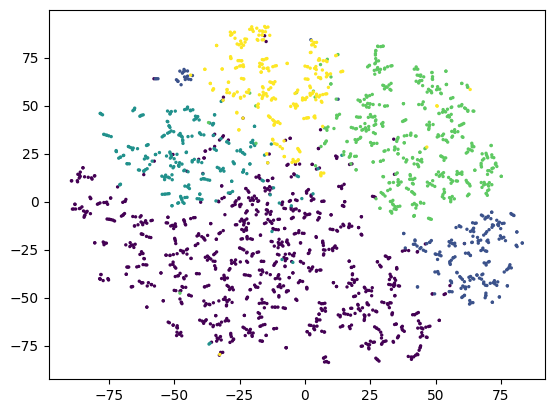

In [87]:
graph_path = os.path.join(folder, 'model', 'bert_Bert.pkl')
dataset = dgl.load_graphs(graph_path)
graph = dataset[0][0]
# X = np.array(graph.nodes[center_node_type][0]['feat'].tolist())
labels = np.array(dataset[1]['paper'].squeeze(1).tolist())
idx = labels < 5
X = torch.load(roberta_path)['paper'].cpu()
X = X[idx]
labels = labels[idx]

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

df = pd.DataFrame(
    {'x': X_embedded[:, 0],
     'y': X_embedded[:, 1],
     'label': labels}
)

from matplotlib import pyplot as plt
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], 2, labels)

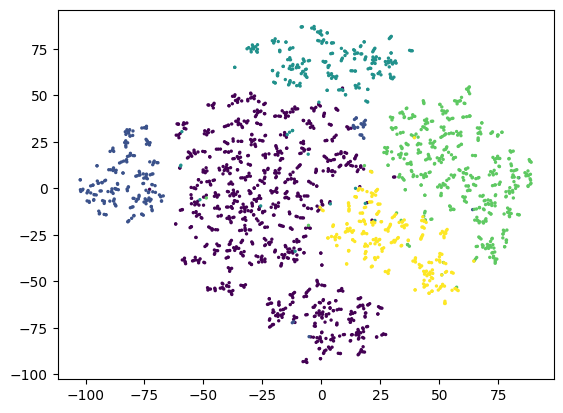

: 

In [89]:
graph_path = os.path.join(folder, 'model', 'bert_Bert.pkl')
dataset = dgl.load_graphs(graph_path)
graph = dataset[0][0]
# X = np.array(graph.nodes[center_node_type][0]['feat'].tolist())
labels = np.array(dataset[1]['paper'].squeeze(1).tolist())
idx = labels < 5
X = torch.load(melon_path)['paper'].cpu()
X = X[idx]
labels = labels[idx]

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

df = pd.DataFrame(
    {'x': X_embedded[:, 0],
     'y': X_embedded[:, 1],
     'label': labels}
)

from matplotlib import pyplot as plt
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], 2, labels)

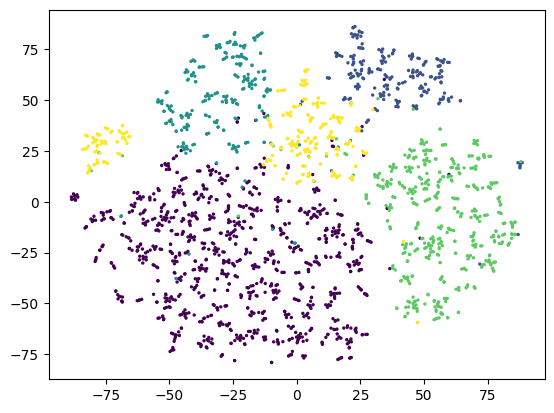

In [88]:
graph_path = os.path.join(folder, 'model', 'bert_Bert.pkl')
dataset = dgl.load_graphs(graph_path)
graph = dataset[0][0]
# X = np.array(graph.nodes[center_node_type][0]['feat'].tolist())
labels = np.array(dataset[1]['paper'].squeeze(1).tolist())
idx = labels < 5
X = torch.load(patton_path)['paper'].cpu()
X = X[idx]
labels = labels[idx]

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

from matplotlib import pyplot as plt
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], 2, labels)

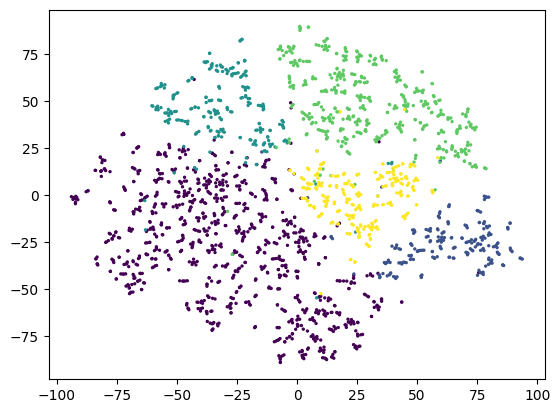

In [69]:
graph_path = os.path.join(folder, 'model', 'bert_Bert.pkl')
dataset = dgl.load_graphs(graph_path)
graph = dataset[0][0]
# X = np.array(graph.nodes[center_node_type][0]['feat'].tolist())
labels = np.array(dataset[1]['paper'].squeeze(1).tolist())
idx = labels < 5
X = torch.load(linkbert_path)['paper'].cpu()
X = X[idx]
labels = labels[idx]

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

from matplotlib import pyplot as plt
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], 2, labels)

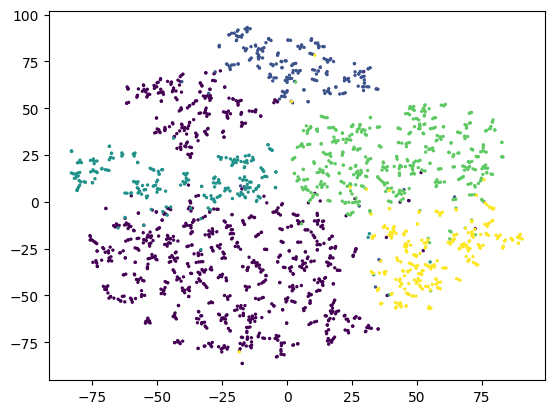

In [74]:
graph_path = os.path.join(folder, 'model', 'bert_Bert.pkl')
dataset = dgl.load_graphs(graph_path)
graph = dataset[0][0]
# X = np.array(graph.nodes[center_node_type][0]['feat'].tolist())
labels = np.array(dataset[1]['paper'].squeeze(1).tolist())
idx = labels < 5
X = torch.load(bert_path)['paper'].cpu()
X = X[idx]
labels = labels[idx]

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

from matplotlib import pyplot as plt
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], 2, labels)

In [ ]:
"f2 test accuracy": {
        "Mar_P_1": 0.5600359859056132,
        "Mar_R_1": 0.5395517465941874,
        "F1_1": 0.548835813999176,
        "ndcg_1": 0.5584850907325745,
        "Mic_P_1": 0.5584850731921672,
        "Mic_R_1": 0.537011117859878,
        "PHR_1": 0.5584850731921672,
        "Mar_P_3": 0.2938906566556124,
        "Mar_R_3": 0.8230010914291477,
        "F1_3": 0.4224562346935272,
        "ndcg_3": 0.714162290096283,
        "Mic_P_3": 0.28585683813499585,
        "Mic_R_3": 0.824596614466422,
        "PHR_3": 0.8324682101562715,
        "Mar_P_5": 0.20064856636194994,
        "Mar_R_5": 0.9347547979309194,
        "F1_5": 0.3213226795196533,
        "ndcg_5": 0.7606496810913086,
        "Mic_P_5": 0.19492461069457032,
        "Mic_R_5": 0.937148440594713,
        "PHR_5": 0.9399082694790036
    }

"f3 test accuracy": {
        "Mar_P_1": 0.6186291360547775,
        "Mar_R_1": 0.5967261597695988,
        "F1_1": 0.6041990518569946,
        "ndcg_1": 0.6144846081733704,
        "Mic_P_1": 0.6144846337645217,
        "Mic_R_1": 0.5908574748461721,
        "PHR_1": 0.6144846337645217,
        "Mar_P_3": 0.3182040452552678,
        "Mar_R_3": 0.8660227411587813,
        "F1_3": 0.4435981512069702,
        "ndcg_3": 0.7623681426048279,
        "Mic_P_3": 0.3001382366134776,
        "Mic_R_3": 0.8657934349169462,
        "PHR_3": 0.8730603389085716,
        "Mar_P_5": 0.21252727791212048,
        "Mar_R_5": 0.9567607309991891,
        "F1_5": 0.32858073711395264,
        "ndcg_5": 0.8005632758140564,
        "Mic_P_5": 0.1993298728406251,
        "Mic_R_5": 0.9583278316212005,
        "PHR_5": 0.9602043338551537
    }

"f4 test accuracy": {
        "Mar_P_1": 0.5823668227888419,
        "Mar_R_1": 0.5591650936835858,
        "F1_1": 0.5667973756790161,
        "ndcg_1": 0.5771881937980652,
        "Mic_P_1": 0.5771882123534097,
        "Mic_R_1": 0.554995114479626,
        "PHR_1": 0.5771882123534097,
        "Mar_P_3": 0.3070713896920866,
        "Mar_R_3": 0.8430472717779041,
        "F1_3": 0.4322114586830139,
        "ndcg_3": 0.7329739928245544,
        "Mic_P_3": 0.29253064550090174,
        "Mic_R_3": 0.8438482055615708,
        "PHR_3": 0.8505396720771196,
        "Mar_P_5": 0.206722913723703,
        "Mar_R_5": 0.944133881744103,
        "F1_5": 0.3245791494846344,
        "ndcg_5": 0.7756205201148987,
        "Mic_P_5": 0.1969020350992832,
        "Mic_R_5": 0.9466553991602187,
        "PHR_5": 0.9489440004394276
    }

In [12]:
df = pd.DataFrame(data=[[0.5600359859056132, 0.5395517465941874, 0.5908574748461721,0.537011117859878],
                   [0.6186291360547775,0.5967261597695988,0.6144846337645217, 0.5908574748461721],
                   [0.5823668227888419,0.5591650936835858,0.5771882123534097,0.554995114479626]],
             columns = ['Mar_P_1','Mar_R_1', 'Mic_P_1', 'Mic_R_1'],
             index=[2,3,4])

Text(0.5, 0, 'metapath length')

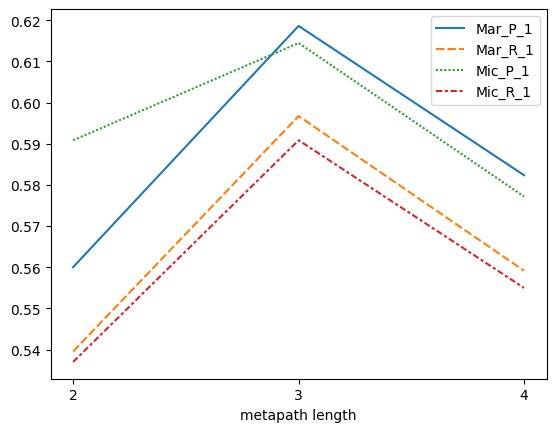

In [16]:
import seaborn as sns
import matplotlib.ticker as ticker
ax = sns.lineplot(data=df)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xlabel('metapath length')